# Проект предсказания коэффициента восстановления золота из золотосодержащей руды

Задача: по данным с промышленного предприятия построить модель для предсказания эффективности работы производства. <br>
Дано: 3 файла с данными, описание технологичесткого процесса, формулы метрик эффективности. <br>
Ожидаемый результат: готовая модель для рассчета эффективности восстановления золота из руды.

## Подготовка данных

In [ ]:
# !pip3 install pandas-profiling==2.11
# from pandas_profiling import ProfileReport

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    make_scorer
)


In [ ]:
data_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')

# ProfileReport(data_train, minimal=True)

### Проверка эффективности обогащения на этапе флотации с помощью MAE

In [ ]:
rougher_recovery_train_calculated = []

# рассчет эффективности на этапе флотации по формуле
rougher_recovery_train_calculated = data_train['rougher.output.concentrate_au'] * (
    data_train['rougher.input.feed_au'] - data_train['rougher.output.tail_au']) / (
        data_train['rougher.input.feed_au'] * (
        data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au'])) * 100

print('MAE для эффективности на этапе флотации по рассчетам и данным =',
      mean_absolute_error(data_train['rougher.output.recovery'], rougher_recovery_train_calculated))

MAE для эффективности на этапе флотации по рассчетам и данным = 9.73512347450521e-15


Получили значение MAE для эффективности этапа флотации на тренировочной выборке, число настолько незначительное, что можно утверждать, что в данных рассчеты верные и данным можно доверять, эффективность рассчитана верно.

### Анализ различий в train и test

In [ ]:
difference = []

difference = set(data_train.columns.to_list()).difference(set(data_test.columns.to_list()))

display(difference)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовых данных отсутствуют колонки, в которых значится концентрация металлов и вспомогательных веществ на выходе после флотации и второго этапа очистки. Логично, что эти данные отсутствуют в тестовой выборке, так как могут быть измерены только во время или после окончания процесса восстановления золота из руды. Также отсутствуют некоторые рассчетные характеристики для этапа флотации. Часть отсутсвующих данных является целевым признаком, а часть - обычным. Предполагается, что отсутсвующие признаки можно удалить из трнировочной выборки, т.к. они будут бесполезны для модели.

### Предобработка данных

In [ ]:
# зададим колонку date как индекс
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%d %H:%M:%S')
data_train.set_index('date', inplace=True)
data_test.set_index('date', inplace=True)
data_full.set_index('date', inplace=True)

In [ ]:
difference = difference - {'rougher.output.recovery', 'final.output.recovery'}
difference = list(difference)

data_train_new = data_train.drop(difference, axis=1)


# проверка на пропуски
print('% пропусков в train', round((data_train.shape[0] - data_train.dropna().shape[0]) / data_train.shape[0] * 100))
print('% пропусков в test', round((data_test.shape[0] - data_test.dropna().shape[0]) / data_test.shape[0] * 100))
print('Пропусков в целевом признаке rougher.recovery', data_train['rougher.output.recovery'].isna().sum())
print('Пропусков в целевом признаке final.recovery', data_train['final.output.recovery'].isna().sum())

# создание списка колонок для заполнения пропусков
columns_list = data_train_new.columns.to_list()

# заполнение пропусков соседним значением
for column in columns_list:
  data_train_new[column] = data_train_new[column].fillna(method='ffill')

data_test = data_test.dropna()

# проверка на пропуски после заполнения
print('% пропусков в train', round((data_train_new.shape[0] - data_train_new.dropna().shape[0]) / data_train_new.shape[0] * 100))
print('% пропусков в test', round((data_test.shape[0] - data_test.dropna().shape[0]) / data_test.shape[0] * 100))



% пропусков в train 22
% пропусков в test 1
Пропусков в целевом признаке rougher.recovery 0
Пропусков в целевом признаке final.recovery 0
% пропусков в train 0
% пропусков в test 0


### Вывод
Провели подготовку данных. Нам предоставлено 3 файла с данными: тренировочные данные, тестовые и файл полных данных.
<br>
Файлы были изучены, проверена корректность рассчета эффективности в данных, рассчеты оказались верны, данным можно доверять. Также была изучена разница в данных в тренировочном и тестовом датасетах, выявлены ненужные признаки, которые были удалены из тренировочной выборки.
<br>
В тренировочной выборке были выявлены пропуски, их было около 10%, это достаточно большое количество пропущенных данных и удалять их будет некорректно. Заполнение величин было выполнено медианой, т.к. у большинства признаков нормальное распределение и данный способ устранения пропусков не должен негативно повлиять на модель.
<br>
Также стоит отметить, что все данные числовые, значит перед нами стоит задача регресии, будем использовать соответсвующие модели.

## Анализ данных

### Изменение концентрации металлов на разных этапах очистки

In [ ]:
# функция для построения графиков концентраций
def draw_plot(df, columns, title):
  plt.figure(figsize=(20,7))
  sns.set_theme()
  sns.set_style("whitegrid")
  sns.lineplot(data=df[columns].groupby(df.index.round('D')).mean(), palette="hls").set(title=title)
  plt.show()
  print('\n\n\n\n')


to_draw = [['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'],
           ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'],
           ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
titles = ['Изменение концентрации Au на выходе со всех этапов очистки',
          'Изменение концентрации Ag на выходе со всех этапов очистки',
          'Изменение концентрации Pb на выходе со всех этапов очистки']

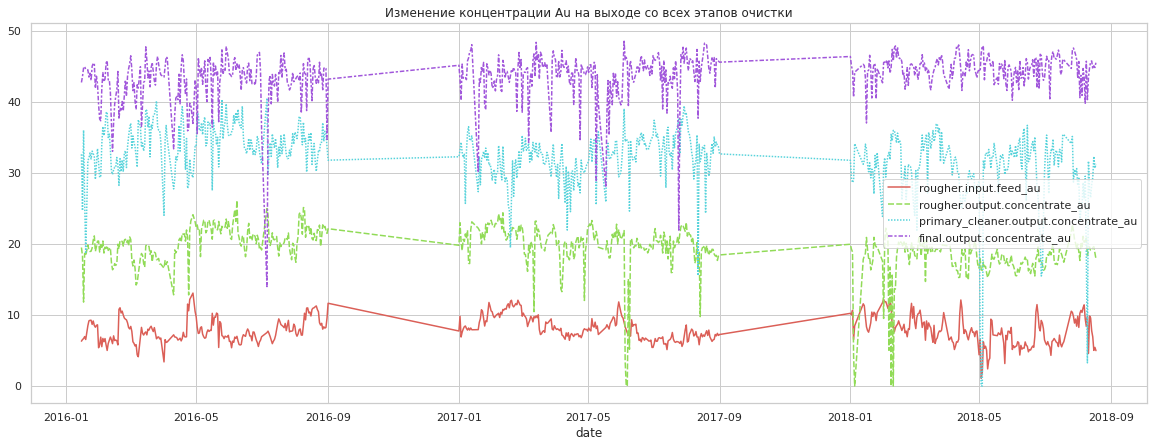

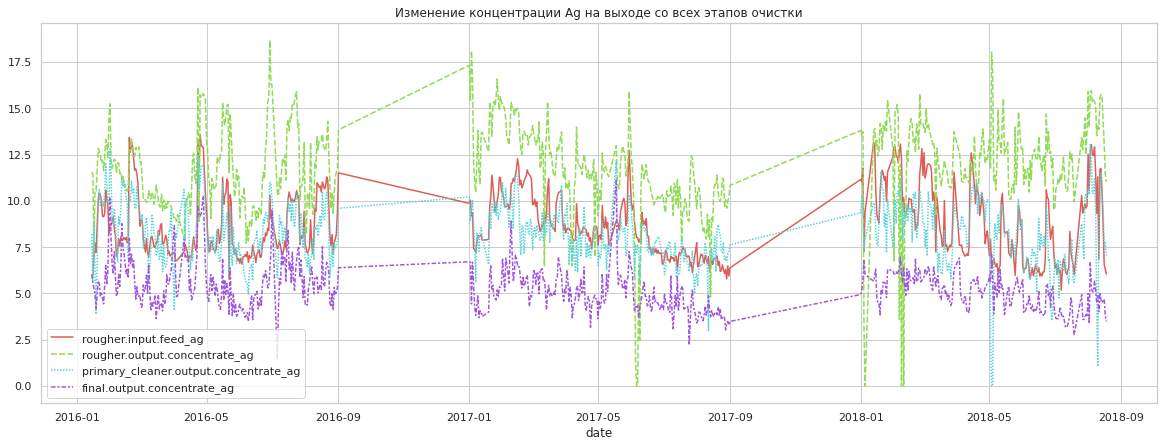

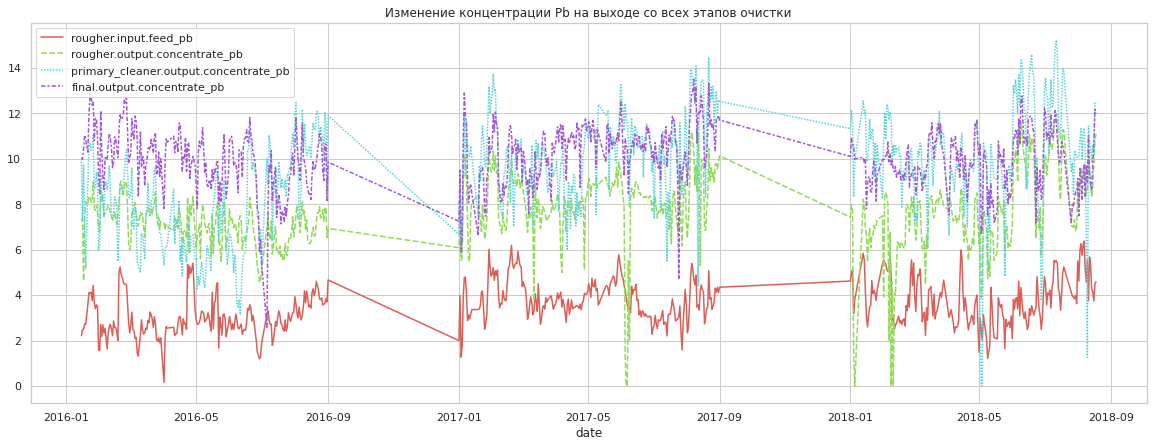

In [ ]:
for i in range(3):
  draw_plot(data_train, to_draw[i], titles[i])

Были построены графики изменения концентрации каждого металла на выходе с каждого этапа. <br>
Видно, что концентрация золота увеличивается к последнему этапу очистки, концетрация серебра возрастала на флотации, но потом наоборот падает, а свинец не имеет заметного изменения концентрации во время очистки, но немного увеличивает концентрацию в сравнении с исходным сырьем. При этом, концентрация золота на выходе больше, чем других металлов, это положительный показатель.
<br>
При этом заметно, что показатели концентраций иногда уходят в 0, видимо это ошибки в данных и эти данные стоит удалить.

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'>👍</font>

### Сравнение распределения размера гранул сырья в train и test на разных этапах очистки

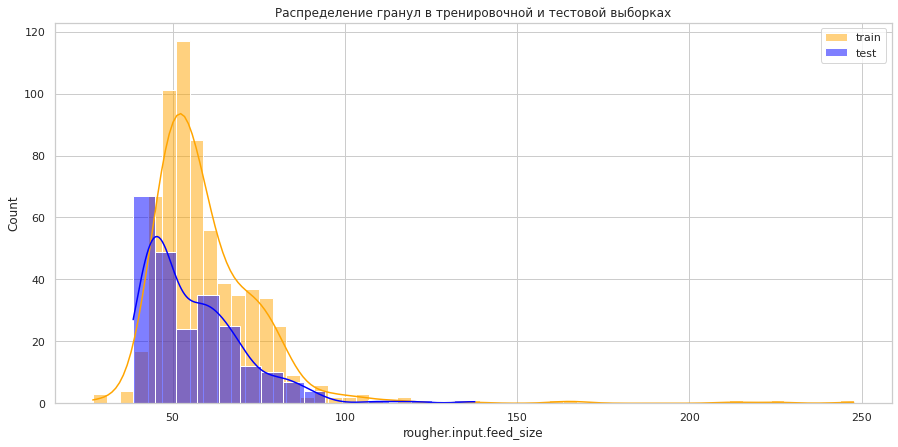

In [ ]:
plt.figure(figsize=(15,7))
sns.histplot(data_train['rougher.input.feed_size'].groupby(data_train.index.floor('D')).agg('mean'),
             kde=True, color='orange', label='train');
sns.histplot(data=data_test['rougher.input.feed_size'].groupby(data_test.index.floor('D')).agg('mean'),
             kde=True, color='blue', label='test').set(title='Распределение гранул в тренировочной и тестовой выборках');
plt.legend();

Исходя из графика, распределение размера поступаемых гранул на обработку в тестовой и тренировочной выборках достаточно схожее, большое количество гранул размера около 50 с последующим плавным уменьшением количества к размеру 100 с редкими более крупными экземплярами. Значит, это не будет препятствовать работе модели.

### Суммарная концентрация веществ на разных этапах очистки

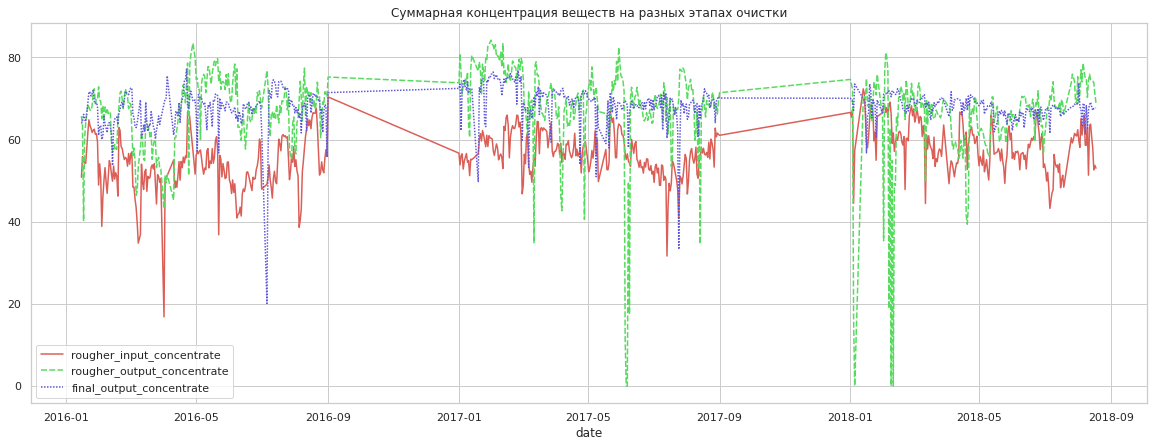

In [ ]:
data_train['rougher_input_concentrate'] = \
    data_train['rougher.input.feed_au'] \
    + data_train['rougher.input.feed_ag'] \
    + data_train['rougher.input.feed_pb'] \
    + data_train['rougher.input.feed_sol']

data_train['rougher_output_concentrate'] = \
    data_train['rougher.output.concentrate_au'] \
    + data_train['rougher.output.concentrate_ag'] \
    + data_train['rougher.output.concentrate_pb'] \
    + data_train['rougher.output.concentrate_sol']

data_train['final_output_concentrate'] = \
    data_train['final.output.concentrate_au'] \
    + data_train['final.output.concentrate_ag'] \
    + data_train['final.output.concentrate_pb'] \
    + data_train['final.output.concentrate_sol']

to_draw = ['rougher_input_concentrate', 'rougher_output_concentrate', 'final_output_concentrate']
title = 'Суммарная концентрация веществ на разных этапах очистки'

draw_plot(data_train, to_draw, title)


Видно, что в суммарных концентрацях веществ также наблюдаются периодические выбросы, стремящиеся к нулю, это подтверждает вывод из первых графиков, в какие-то моменты замеры не проводились или же были записаны с ошибкой. Эти данные из выборки нужно удалить. <br>
При этом стоит отметить, что сумма финальных концентраций меняется с малой амплитудой, что говорит о стабильности исследуемого производства.  

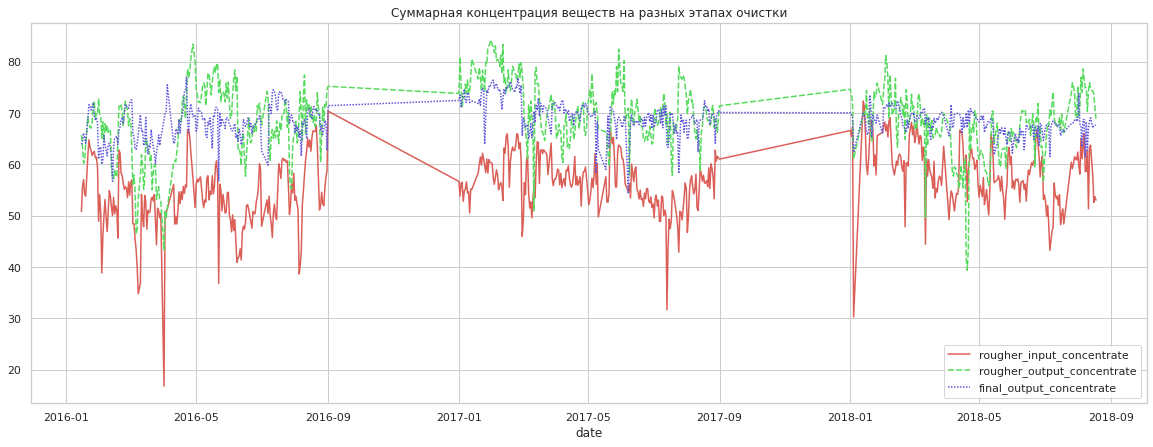

In [ ]:
# создаем список колонок, которые содержат данные о концентрациях веществ
null_columns = [col for col in data_train.columns if 'concentrate' in col]
null_columns.extend(['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol'])

# удаление строк, где есть хоть одна нулевая концентрация в выбранных колонках
for column in null_columns:
  data_train = data_train[data_train[column] != 0]

# аналогичное удаление 0 в уже отредактированной тренировочной выборке
for column in data_train_new.columns:
  data_train_new = data_train_new[data_train_new[column] != 0]

draw_plot(data_train, to_draw, title)


Было решено удалить строки, в которых концентрации металов и солей были равн 0, т.к. вероятнее всего это или ошибочные данные или же отсутствие измерений. Такие данные не помогут модели обучиться. <br>
На обновленном датасете без 0 был повторно построен график суммарных концентраций веществ и теперь он выглядит лучше, от выбросов избавились.

### Вывод
Были построены графики изменения концентрации каждого металла на выходе с каждого этапа.
Видно, что концентрация золота увеличивается к последнему этапу очистки, концетрация серебра наоборот падает, а свинец не имеет заметного изменения концентрации. При этом, концентрация золота на выходе больше, чем других металлов, это положительный показатель. <br>
После изучения распределения размера гранул входного сырья для тренировочной и тестовой выборок было визуально установлено, что распределения схожие и это не будет влиять на обучение модели. <br>
Проведенные анализ данных помог избавиться от неправильных данных в тренировочной выборке: концентрации, равные 0 были удаленв как некорректные и мешающие обучению модели.


## Построение модели


### Функция для итогового sMAPE

In [ ]:
def smape(target, predictions):
  return 1/len(target) * np.sum(2 * np.abs(target - predictions) / (np.abs(target) + np.abs(predictions))*100)


def smape_final(predictions_r, target_r, predictions_f, target_f):
  return 0.25 * smape(predictions_r, target_r) + 0.75 * smape(predictions_f, target_f)


### Обучение моделей


#### Подготовка выборок и масштабирование

In [ ]:
# разделение на выборки и удаление ненужных столбцов

target_train_r = data_train_new['rougher.output.recovery']
target_train_f = data_train_new['final.output.recovery']

target_test_r = data_full.loc[data_test.index, 'rougher.output.recovery']
target_test_f = data_full.loc[data_test.index, 'final.output.recovery']

features_train = data_train_new.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = data_test

In [ ]:
# проверка размеров датасетов после разделения на выборки и сравнение с размерностью тестовой
print(target_train_r.shape, target_train_f.shape, features_train.shape, target_test_r.shape, target_test_f.shape, features_test.shape)


(13769,) (13769,) (13769, 52) (5229,) (5229,) (5229, 52)


In [ ]:
# используем MinMaxScaler для масштабирования признаков
scaler_m = MinMaxScaler()
scaler_m.fit(features_train)
features_train = scaler_m.transform(features_train)
features_test = scaler_m.transform(features_test)


На этом этапе произвели разбивку на выборки и целевые признаки. Дополнительно провели масштабирование признаков для лучшей работы линейных функций.

#### Модель LinearRegression

In [ ]:
# используем функцию sMAPE как кастомную оценку работы модели
smape_scorer = make_scorer(smape, greater_is_better=False)
model_lr_r = LinearRegression()
scores_lr_r = cross_val_score(model_lr_r, features_train, target_train_r, scoring=smape_scorer)
print('Средняя оценка sMAPE для этапа флотации на модели линейной регрессии', round(abs(scores_lr_r.mean()), 2))

model_lr_f = LinearRegression()
scores_lr_f = cross_val_score(model_lr_f, features_train, target_train_f, scoring=smape_scorer)
print('Средняя оценка sMAPE для этапа очистки на модели линейной регрессии',round(abs(scores_lr_f.mean()), 2))

Средняя оценка sMAPE для этапа флотации на модели линейной регрессии 7.2
Средняя оценка sMAPE для этапа очистки на модели линейной регрессии 10.95


#### Модель Lasso

In [ ]:
model_lasso_r = Lasso(random_state=12345)
parameters = {'alpha': np.arange(0.00, 2.0, 0.1)}
lasso_r = GridSearchCV(model_lasso_r, parameters, scoring=smape_scorer)
scores_lasso_r = lasso_r.fit(features_train, target_train_r)
print('Лучшая оценка sMAPE для этапа флотации на модели Lasso', round(abs(scores_lasso_r.best_score_), 2))
print(scores_lasso_r.best_params_)

model_lasso_f = Lasso(random_state=12345)
parameters = {'alpha': np.arange(0.00, 2.0, 0.1)}
lasso_f = GridSearchCV(model_lasso_f, parameters, scoring=smape_scorer)
scores_lasso_f = lasso_f.fit(features_train, target_train_f)
print('Лучшая оценка sMAPE для этапа очистки на модели Lasso', round(abs(scores_lasso_f.best_score_), 2))
print(scores_lasso_f.best_params_)

Лучшая оценка sMAPE для этапа флотации на модели Lasso 6.68
{'alpha': 0.1}
Лучшая оценка sMAPE для этапа очистки на модели Lasso 9.32
{'alpha': 0.1}


#### Модель ElasticNet

In [ ]:
model_el_r = ElasticNet(random_state=12345)
parameters = {'alpha' : [1e-2, 1e-1, 0.1, 0.5, 1.0],
              'l1_ratio': np.arange(0, 1, 0.1)}
el_r = GridSearchCV(model_el_r, parameters, scoring=smape_scorer, cv=5)
scores_el_r = el_r.fit(features_train, target_train_r)
print('Лучшая оценка sMAPE для этапа флотации на модели ElasticNet', round(abs(scores_el_r.best_score_), 2))
print(scores_el_r.best_params_)

model_el_f = ElasticNet(random_state=12345)
parameters = {'alpha' : [1e-2, 1e-1, 0.1, 0.5, 1.0],
              'l1_ratio': np.arange(0, 1, 0.1)}
el_f = GridSearchCV(model_el_f, parameters, scoring=smape_scorer, cv=5)
scores_el_f = el_r.fit(features_train, target_train_f)
print('Лучшая оценка sMAPE для этапа очистки на модели ElasticNet', round(abs(scores_el_f.best_score_), 2))
print(scores_el_f.best_params_)

Лучшая оценка sMAPE для этапа флотации на модели ElasticNet 6.01
{'alpha': 0.01, 'l1_ratio': 0.0}
Лучшая оценка sMAPE для этапа очистки на модели ElasticNet 9.3
{'alpha': 0.1, 'l1_ratio': 0.9}


#### Вывод
Были проверены 3 модели регрессии. Для признаков было проведено масштабирование с помощью MinMaxScaller (на нем показатели улучшились примерно на 1-1.5%). <br>
LinearRegression, Lasso и ElasticNet модели были обучены и подобраны лучшие гиперпараметры (для двух последних моделей) с помощью GridSearchCV, проведена кросс-валидация на обучающей выборке. <br>
Лучшей оказалась модель ElasticNet, ее и будем использовать для подсчета эффективности на тестовой выборке.

### Тест модели и рассчет итоговой sMAPE

In [ ]:
model_r = ElasticNet(alpha=0.01, l1_ratio=0, random_state=12345)
model_r.fit(features_train, target_train_r)
predictions_r = model_r.predict(features_test)

model_f = ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=12345)
model_f.fit(features_train, target_train_f)
predictions_f = model_f.predict(features_test)


print('Значение итоговой оценки для предсказаний на тестовой выборке составило:',
      round(smape_final(target_test_r, predictions_r, target_test_f, predictions_f),2), '%')

Значение итоговой оценки для предсказаний на тестовой выборке составило: 7.96 %


In [ ]:
dummy_regr_r = DummyRegressor(strategy="mean")
dummy_regr_r.fit(features_train, target_train_r)
predictions_r = dummy_regr_r.predict(features_test)

dummy_regr_f = DummyRegressor(strategy="mean")
dummy_regr_f.fit(features_train, target_train_f)
predictions_f = dummy_regr_f.predict(features_test)

print('Значение итоговой оценки для предсказаний на тестовой выборке на dummy модели составило:',
      round(smape_final(target_test_r, predictions_r, target_test_f, predictions_f),2), '%')

Значение итоговой оценки для предсказаний на тестовой выборке на dummy модели составило: 9.4 %


### Вывод
На этом этапе были изучены вероятные кандидаты на роль лучшей модели. После подготовки выборок и создания оценки sMAPE мы проверели 3 модели регресии: LinearRegression, Lasso и ElasticNet. С помощью кросс-валидации и подбора гиперпараметров была найдена лушая модель, ею стала ElasticNet и на ее основании были сделаны предсказания на тестовой выборке. <br>
После подсчета искомой метркии финального sMAPE для результатов предсказаний по тестовой выборке мы получили результат для sMAPE ~ 8%. <br>Сравнили значение метрики с константной моделью, ее результат оказался очти 10%. <br>
У нашей модели достаточно низкое значение и ее можно рекомендовать для оценки эффективности производства.

## Общий вывод
Стояла задача построения модели предсказаний эффективности восстановления золота из руды для промышленного предприятия. <br>
Нам было предоставлено 3 файла с данными: тренировочные данные, тестовые и файл полных данных.
Файлы были изучены, проверена корректность рассчета эффективности в данных.
Также был изучен технологический процесс предприятия для лучшего понимания и более продуктивной работы с данными.
<br>
Были изучены концентрации различных металлов на разных стадиях очистки, от поступающего сырью до готового продукта на выходе.
Проведенные анализ данных помог избавиться от неправильных данных в тренировочной выборке: концентрации, равные 0 были удалены как некорректные и мешающие обучению модели. <br>
Далее были изучены вероятные кандидаты на роль лучшей модели. После подготовки выборок и создания оценки sMAPE мы проверели 3 модели регресии: LinearRegression, Lasso и ElasticNet. С помощью кросс-валидации и подбора гиперпараметров была найдена лушая модель, ею стала ElasticNet и на ее основании были сделаны предсказания на тестовой выборке.
После подсчета искомой метрики финального sMAPE для результатов предсказаний по тестовой выборке мы получили результат для sMAPE ~ 8%.
Это достаточно низкое значение и модель можно рекомендовать для оценки эффективности производства.
